# Groeps Opdracht CI
## Joost Vledder, Sadjia Safdari, Simon Kreulen & Jasper van Eck

### Inhoudsopgave <a name='Top'></a>

[Imports](#import)

[Load data](#loaddata)

[Content Based Filtering Algorithm](#contentbased)

[Data Clean Up](#cleanup)

[Basic Data Stats](#basicdata)

[Plots](#plots)

[Cosine Similiraty Content Based](#cossim)

[Query vector](#queryvector)

[SVD](#svd)

[K-Means](#kmeans)

[Cohen Kappa](#cohenkappa)

[Item-Based Collaborative Filtering Algorithm](#itembasedcollab)

[Basic Data Stats for Collabaritive Filtering](#basicdatacollab)

[Implementation](#implementation)

[Deel 1: Mesa](#mesa)

[Deel 2: Calgary](#calgary)


### Imports <a name='import'></a>

[Top](#Top)

In [1]:
import os
import pandas as pd
import numpy as np
np.seterr(divide='raise', over='raise', under='raise', invalid='raise')
import matplotlib.pyplot as plt
from collections import defaultdict
import json
#pip install geopy
from geopy import geocoders
from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import TruncatedSVD

### Load data <a name='loaddata'></a>

[Top](#Top)

In [2]:
#rootdir = './yelp/data'
rootdir = './yelp/data/Henderson'

df_business = pd.DataFrame()
df_users = pd.DataFrame()
df_reviews = pd.DataFrame()

count = 0

def load_jsons(data_path, file):
    # function to help load json files, since sometimes they give utf8 encoding errors, sometimes they don't
    file_path = os.path.join(subdir, file)
    lines = []
    with open(file_path) as jsons:
        try:
            lines = [json.loads(json_line) for json_line in jsons]
        except:
            print(file_path)
    return pd.DataFrame(lines)

for subdir, dirs, files in os.walk(rootdir):
    if count == 200: #1078 is the total amount of cities
        break
        
    for file in files:
        if os.path.basename(file) == 'business.json':
            df_business = df_business.append(load_jsons(subdir, file))
        if os.path.basename(file) == 'user.json':
            df_users = df_users.append(load_jsons(subdir, file))
        if os.path.basename(file) == 'review.json':
            df_reviews = df_reviews.append(load_jsons(subdir, file))
    count += 1

df_business = df_business.set_index('business_id')
df_users = df_users.set_index('user_id')
df_reviews = df_reviews.set_index('review_id')

display(df_business.head())
display(df_users.head())
display(df_reviews.head())

,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
business_id,,,,,,,,,,,,,
M9DM1ktbW-TB7nXu3Z4RDw,Sonoma Village,1318 S Vineyard,Mesa,AZ,85210,33.391003,-111.843620,2.5,6,1,"{'BusinessAcceptsCreditCards': 'True', 'ByAppo...","Home Services, Real Estate, Apartments, Hotels...","{'Monday': '9:0-18:0', 'Tuesday': '9:0-18:0', ..."
5ws3QWQXUhqTeLd7IZsDww,"Stephen L Walker, DDS, MS","2220 W Southern Ave, Ste 102, Endodontic Speci...",Mesa,AZ,85202,33.393546,-111.878890,5.0,3,1,{'ByAppointmentOnly': 'True'},"Health & Medical, Endodontists, Dentists","{'Monday': '7:0-19:30', 'Tuesday': '7:0-19:30'..."
viivlh_KJkiDVxhIdZnV8Q,Club Red,1306 W University Dr,Mesa,AZ,85201,33.422164,-111.859035,2.5,64,1,"{'BusinessAcceptsBitcoin': 'False', 'Ambience'...","Arts & Entertainment, Dance Clubs, Nightlife, ...",None
HHH_mrl-x694asUCs3SHeQ,Inspire! Dental,"4434 E Brown Rd, Ste 104",Mesa,AZ,85205,33.437778,-111.734964,5.0,26,1,"{'BusinessAcceptsCreditCards': 'True', 'ByAppo...","General Dentistry, Dentists, Oral Surgeons, Co...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-17:0', '..."
qhkfFrB7IA9AlT-cSl2NSQ,SimonMed Imaging - Mesa Drive,456 N Mesa Dr,Mesa,AZ,85201,33.423710,-111.823369,1.5,18,1,{'ByAppointmentOnly': 'False'},"Doctors, Diagnostic Services, Health & Medical...","{'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ..."


,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,average_stars,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
user_id,,,,,,,,,,,,,,,,,,,,,
4XChL029mKr5hydo79Ljxg,Jenna,33,2013-02-21 22:29:06,48,22,16,,"kEBTgDvFX754S68FllfCaA, aB2DynOxNOJK9st2ZeGTPg...",4,3.63,...,0,0,0,0,0,0,1,1,0,0
_DaFdmq0gtXf1spn1qC_1Q,Edie,77,2009-10-26 01:00:40,71,16,22,,"tYyOnNs7tBfqAT9ICKDfhA, 8lOmKlym2HovbxtCpim0tw...",3,3.48,...,1,0,0,0,2,2,1,1,0,0
WnwpWcNcJhHi39gdIUfJuQ,Larry,81,2010-07-05 17:03:04,336,131,160,,"mJjxrTHfAxQMzEJdxqX5Rw, yrGIgk5eaWy-eewLNv4KHQ...",8,3.21,...,1,0,0,0,10,15,15,15,4,4
U4INQZOPSUaj8hMjLlZ3KA,Michael,4308,2008-01-31 02:55:30,22757,10209,16249,"2008,2010,2011,2012,2013,2014,2015","yqumc_CYlWeghZ5vM3Ilyw, mX84lBw8jwS2uQqdgKu_aA...",912,3.88,...,75,43,13,52,442,656,801,801,663,634
vGDII1284LVonpfLUN6nTA,Celine,9,2016-02-29 18:46:32,7,3,1,,"atThUJe5Rx6WOb54bI9-pA, XY44F0zSaFszPMMvHJQOmw...",0,2.78,...,0,0,0,0,0,1,0,0,0,0


,user_id,business_id,stars,useful,funny,cool,text,date
review_id,,,,,,,,
-I5umRTkhw15RqpKMl_o1Q,-mA3-1mN4JIEkqOtdbNXCQ,mRUVMJkUGxrByzMQ2MuOpA,1.0,0,1,0,"Walked in around 4 on a Friday afternoon, we s...",2017-12-15 23:27:08
I9HBDyzCqLhTYHCAZIFZQQ,vXZeHaLvdfCPATz5BDavow,FQ1wBQb3aNeRMThSQEV0Qg,5.0,4,0,0,PlumbSmart provided superior service from begi...,2013-12-07 02:32:45
NfK6qaAr5QgbuMG0XDbpuQ,-bFRtLmkx7aXKf0oqFKpRg,1Kq_blM7ROYESz6i6FI_QQ,4.0,1,0,0,"I've taken my kids here several times, and we'...",2013-05-07 03:40:19
NFlW7_5bOPkR2Nz8t9d2Sw,qkQ5iVnEdqSxjd3faoRTpw,Kz4WS00PcqOJgxfZawk4dQ,4.0,0,0,1,"I love Pizza, but I try to stay away for dieta...",2013-12-07 01:41:25
niN5qW_M5Y0W0zQEcQcFig,n5E4KzRRGosdxNcdyyZztg,9nHpqlu7be1466wdo_t5kQ,2.0,0,0,0,My family and I came in on Wed. Night for dinn...,2018-03-15 20:12:39


In [3]:
df_business.to_pickle('./business_pickle.pkl')
df_users.to_pickle('./users_pickle.pkl')
df_reviews.to_pickle('./reviews_pickle.pkl')

In [4]:
df_business = pd.read_pickle('./business_pickle.pkl')
df_users = pd.read_pickle('./users_pickle.pkl')
df_reviews = pd.read_pickle('./reviews_pickle.pkl')

### Clean up Data For Content Based <a name='cleanup'></a>

[Top](#Top)

In [5]:
cat_dict = defaultdict(lambda: defaultdict(int))

# Drop na categories
df_business = df_business[df_business['categories'].notna()]

# Normalize long, lat, stars & review_count
#x = cos(lat) * cos(lon)
#y = cos(lat) * sin(lon)
df_business['stars'] = (df_business['stars']-df_business['stars'].min()) / (df_business['stars'].max()-df_business['stars'].min())
df_business['review_count'] = (df_business['review_count']-df_business['review_count'].min()) / (df_business['review_count'].max()-df_business['review_count'].min())
#df_business['x_axis'] = np.cos(df_business['latitude']) * np.cos(df_business['longitude'])
#df_business['y_axis'] = np.cos(df_business['latitude']) * np.sin(df_business['longitude'])

# Dataframe of categories one hot encoded per business_id
df_tmp = df_business['categories'].str.split(pat=', ',expand=True)

# Create dict of categories
for index, row in df_tmp.iterrows():
    for _,elem in row.items():
        if elem and elem not in cat_dict[index]:
            cat_dict[index][elem] += 1  

In [6]:
# Create DF from dict
df_cats = pd.DataFrame.from_dict(cat_dict, orient='index')

#Drop NaN column
df_cats = df_cats.drop(columns='NaN',errors='ignore')

# Fillna with 0
df_cats = df_cats.fillna(0)

# Join back into business
df_business = df_business.join(df_cats,on='business_id')

# Drop cols
df_business = df_business.drop(columns=['address','state','postal_code','attributes','categories','hours'],errors='ignore')

# Remove elite & friends columns because of non use
df_users = df_users.drop(columns=['elite','friends'],axis=1,errors='ignore')

In [7]:
df_business.to_pickle('./business_pickle.pkl')
df_users.to_pickle('./users_pickle.pkl')
df_reviews.to_pickle('./reviews_pickle.pkl')

In [8]:
df_business = pd.read_pickle('./business_pickle.pkl')
df_users = pd.read_pickle('./users_pickle.pkl')
df_reviews = pd.read_pickle('./reviews_pickle.pkl')

### Basic Data Stats for Content Based <a name='basicdata'></a>

[Top](#Top)

In [9]:
# Some information about the category amounts per business

# series of amount of categories per business
cats_business = df_cats.sum(axis=1).sort_values(ascending=False)
display(cats_business)

avg_cats_bus = cats_business.mean()
max_cats_bus = cats_business.max()
min_cats_bus = cats_business.min()

print('Average amount of categories for businesses: ', avg_cats_bus)
print('Minimum amount of categories for businesses: ', min_cats_bus)
print('Maximum amount of categories for businesses: ', max_cats_bus)

# series of amount of businesses with the index amount of categories
cat_bus_distribution = cats_business.value_counts()
display(cat_bus_distribution)

vl4z9uGNc80Xt7qB9V1fdA    16.0
YlGlRu9EqdpNBHhj0_WNTg    14.0
3zEmUdV433P1OYUCUY8r2w    14.0
b57K2E8KOydTMitADS-JVw    13.0
6LHhI1p9PfUGNq3OWJVLPg    13.0
                          ... 
OQSHcpZcVDMZztwD6Ngt7Q     1.0
ULTxTn0oJTyhg9v-B8XOIQ     1.0
VAXp38_w_6L8iHxYIcuGAQ     1.0
rqrCei8Bi4t5OJlkqdjBYQ     1.0
O-5wKYl00RYTNwym40UNWw     1.0
Length: 6071, dtype: float64

Average amount of categories for businesses:  4.141986493164223
Minimum amount of categories for businesses:  1.0
Maximum amount of categories for businesses:  16.0


2.0     1526
3.0     1186
4.0     1121
5.0      883
6.0      548
7.0      389
8.0      169
9.0      105
10.0      55
11.0      31
1.0       25
12.0      21
13.0       9
14.0       2
16.0       1
dtype: int64

In [10]:
# series of number of businesses with index as category
cats_presences = df_cats.sum(axis=0).sort_values(ascending=False)
display(cats_presences)

avg_cats = cats_presences.mean()
max_cats = cats_presences.max()
min_cats = cats_presences.min()

print('Average amount of presence of a category: ', avg_cats)
print('Minimum amount of presence of a category: ', min_cats)
print('Maximum amount of presences of a category: ', max_cats)

Restaurants          1169.0
Home Services        1107.0
Shopping             1089.0
Health & Medical      774.0
Automotive            761.0
                      ...  
Aquariums               1.0
Pet Breeders            1.0
Dental Hygienists       1.0
Souvenir Shops          1.0
Spine Surgeons          1.0
Length: 922, dtype: float64

Average amount of presence of a category:  27.273318872017352
Minimum amount of presence of a category:  1.0
Maximum amount of presences of a category:  1169.0


### Plots <a name='plots'></a>

[Top](#Top)

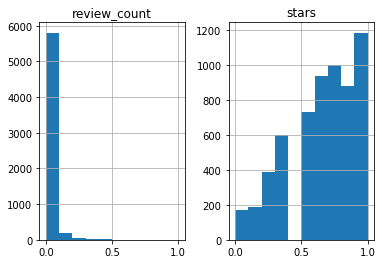

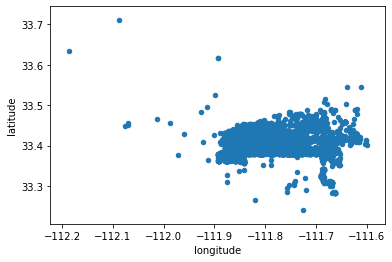

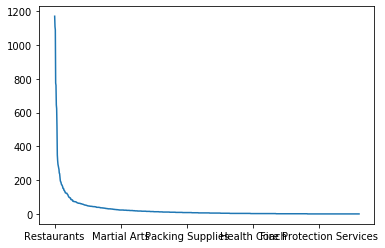

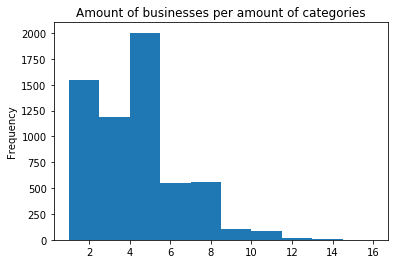

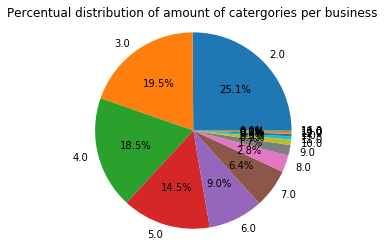

In [11]:
hist_bus = df_business.hist(column=['stars','review_count'])
#df_business.plot(x='x_axis',y='y_axis',kind='scatter')
df_business.plot(x='longitude',y='latitude',kind='scatter')
plt.show()
cats_presences.plot()
plt.show()

cats_business.plot(kind='hist',subplots=False,sharex=False,sharey=False,title='Amount of businesses per amount of categories')
plt.show()

total_cats = sum(cat_bus_distribution.values)
percentages = [(value/total_cats) * 100 for value in cat_bus_distribution.values]

fig1, circle = plt.subplots()
circle.pie(percentages, labels=cat_bus_distribution.index, autopct='%1.1f%%')
circle.axis('equal')
plt.title('Percentual distribution of amount of catergories per business')
plt.show()

In [12]:
df_business = pd.read_pickle('./business_pickle.pkl')
df_cats = pd.read_pickle('./cats_pickle.pkl')
df_users = pd.read_pickle('./users_pickle.pkl')
df_reviews = pd.read_pickle('./reviews_pickle.pkl')

FileNotFoundError: [Errno 2] No such file or directory: './cats_pickle.pkl'

### Cosine Similarity <a name='cossim'></a>

[Top](#Top)

In [13]:
# Input vectors are series, convert to np array
def cosineSim(vector, docVector):
    vector = vector.to_numpy()
    docVector = docVector.to_numpy()
    
    # Get lengths of vectors
    sim = (np.sqrt(sum(vector**2))*np.sqrt(sum(docVector**2)))
    
    # Ensure no division by 0
    if sim == 0.:
        return np.nan
    
    # Calculate cosine sim
    return vector.dot(docVector)/sim

In [14]:
def rankedBusinessList(df_business, queryVector):
    df_bus_features = df_business.copy().drop(columns=['name','city','stars','review_count','is_open','Score Cos'],errors='ignore')
    scoreList = np.zeros(len(df_business))
    for i in range(len(df_bus_features)):
        scoreList[i] = cosineSim(queryVector, df_bus_features.iloc[i])
    
    df_business['Score Cos'] = scoreList
    return df_business.sort_values(by=['Score Cos','stars'],ascending=False)

### Create Query Vector <a name='queryvector'></a>

[Top](#Top)

This first cell get the longitude and latitude of a given city and state, and normalizes both values.

In [15]:
display(df_business['city'].value_counts().sort_values(ascending=False))

Mesa    6062
MESA       6
mesa       3
Name: city, dtype: int64

In [16]:
loc_string = 'Scottsdale AZ'
gn = Nominatim(user_agent='WalterGKurtz')
location = gn.geocode(loc_string)
queryVector = pd.Series(data=0.,index=df_business.columns)
queryVector.at['latitude'] = location.latitude
queryVector.at['longitude'] = location.longitude
#x = cos(lat) * cos(lon)
#y = cos(lat) * sin(lon)
#queryVector.at['x_axis'] = np.cos(location.latitude) * np.cos(location.longitude)
#queryVector.at['y_axis'] = np.cos(location.latitude) * np.sin(location.longitude)


The second cell inputs the preferences of the user.

In [17]:
# Preferences
queryVector = queryVector.drop(labels=['name','city','stars','review_count','is_open'],errors='ignore')
queryVector.at['Automotive'] = 1.
queryVector.at['Auto Repair'] = 1.
queryVector.at['Fast Food'] = 1.
queryVector.at['Restaurants'] = 1.
queryVector.at['Pizza'] = 1.
queryVector.at['Men\'s Clothing'] = 1.
queryVector.at['Women\'s Clothing'] = 1.
queryVector.at['Fashion'] = 1.
queryVector.at['Bars'] = 1.
display(queryVector)
#queryVector.to_csv('test.csv', header=False)

latitude                       33.494219
longitude                    -111.926018
Home Services                   0.000000
Real Estate                     0.000000
Apartments                      0.000000
                                 ...    
LAN Centers                     0.000000
Tapas/Small Plates              0.000000
Casinos                         0.000000
Ultrasound Imaging Centers      0.000000
Spine Surgeons                  0.000000
Length: 924, dtype: float64

In [18]:
display(rankedBusinessList(df_business,queryVector).head(20))

,name,city,latitude,longitude,stars,review_count,is_open,Home Services,Real Estate,Apartments,...,Foundation Repair,Town Car Service,Car Buyers,Virtual Reality Centers,LAN Centers,Tapas/Small Plates,Casinos,Ultrasound Imaging Centers,Spine Surgeons,Score Cos
business_id,,,,,,,,,,,,,,,,,,,,,
WQAaGMguMmnxQdgMeEFY9g,Little Caesar's Pizza,Mesa,33.436141,-111.815404,0.750,0.007506,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999780
ZI6CBpptCb1Nw-udZ8wonw,Pizza Hut,Mesa,33.417347,-111.788637,0.125,0.000000,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999780
mJ0CA86roChYwaDkDxFGwg,Papa John's Pizza,Mesa,33.432942,-111.843711,0.500,0.004170,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999780
qVtPl0PtlynFEKz8Qa3RcQ,MOD Pizza,Mesa,33.472347,-111.701723,0.750,0.018349,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999780
Uq2mwlWCav51N5AW16XubQ,Joe's AC & Auto Repair,Mesa,33.452500,-111.777911,0.875,0.004170,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999744
42BiG81eN2nD8mikGADftA,Herlehy's Complete Auto Repair,Mesa,33.452500,-111.777908,1.000,0.007506,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999744
04YqYgoW2ZztLpxmhEJ43Q,Little Caeser's Pizza,Mesa,33.452207,-111.771227,0.375,0.002502,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999744
8CYVg6GtuVb4yo0_V2_bQA,Little Caesar's Pizza,Mesa,33.452207,-111.771224,0.375,0.005004,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999744
JznTpiPQVpfnV7mEw6PpOQ,Papa Murphy's,Mesa,33.452025,-111.803620,0.750,0.005838,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999744


### SVD <a name='svd'></a>

[Top](#Top)

In [19]:
stars = df_business['stars'].values
cities = df_business['city'].values
names = df_business['name'].values
bus_ids = df_business.index
df_tmp_svd = df_business.copy().drop(columns=['name','city', 'stars','review_count','is_open', 'Score Cos'],errors='ignore').to_numpy()

In [20]:
# This code can be used to find the optimal amount of dimension by the SVD

# trunc_svd = TruncatedSVD(n_components=len(df_tmp_svd[0])-1).fit(df_tmp_svd)
# reduced_x = trunc_svd.transform(df_tmp_svd)
# singles = trunc_svd.singular_values_

# eigvals = singles**2 / np.sum(singles**2)
# fig = plt.figure(figsize=(8,5))
# sing_vals = np.arange(len(df_tmp_svd[0])-1) + 1
# plt.plot(sing_vals[2:200], eigvals[2:200], 'ro-', linewidth=2)
# plt.title('Scree Plot')
# plt.xlabel('Component number')
# plt.ylabel('Eigenvalue')
# plt.show()

In [21]:
optimal_dims = 25
trunc_svd = TruncatedSVD(n_components=optimal_dims).fit(df_tmp_svd)
reduced_x = trunc_svd.transform(df_tmp_svd)

In [22]:
queryVectorReduced = trunc_svd.transform(np.array([queryVector]))

df_reduced_x = pd.DataFrame(data=reduced_x, index=bus_ids)
df_reduced_x.insert(0, 'stars', stars)
df_reduced_x.insert(0, 'city', cities)
df_reduced_x.insert(0, 'name', names)
df_queryVectorReduced = pd.Series(data=queryVectorReduced[0])
display(rankedBusinessList(df_reduced_x,df_queryVectorReduced).head(20))

,name,city,stars,0,1,2,3,4,5,6,...,16,17,18,19,20,21,22,23,24,Score Cos
business_id,,,,,,,,,,,,,,,,,,,,,
qVtPl0PtlynFEKz8Qa3RcQ,MOD Pizza,Mesa,0.750,116.610328,0.917573,-0.330267,0.048766,-0.029250,-0.076393,0.179852,...,-0.044481,0.331698,0.318665,0.016028,0.036179,0.100843,-0.420000,-0.052044,0.043900,0.999882
WQAaGMguMmnxQdgMeEFY9g,Little Caesar's Pizza,Mesa,0.750,116.708881,0.917688,-0.330115,0.048853,-0.029247,-0.076464,0.179881,...,-0.043876,0.331299,0.318707,0.016072,0.036106,0.101072,-0.419845,-0.052299,0.043550,0.999882
mJ0CA86roChYwaDkDxFGwg,Papa John's Pizza,Mesa,0.500,116.735087,0.917708,-0.330083,0.048862,-0.029249,-0.076470,0.179890,...,-0.043763,0.331233,0.318713,0.016081,0.036094,0.101116,-0.419820,-0.052345,0.043483,0.999882
ZI6CBpptCb1Nw-udZ8wonw,Pizza Hut,Mesa,0.125,116.677854,0.917701,-0.330127,0.048893,-0.029232,-0.076507,0.179868,...,-0.043840,0.331238,0.318718,0.016072,0.036090,0.101078,-0.419812,-0.052322,0.043540,0.999882
-c_MUp1XdJnC8LofTEPLTA,Red Brick Pizza,Mesa,0.625,116.734374,0.960989,-0.350275,0.053844,-0.029558,-0.083930,0.191964,...,-0.041349,0.280915,0.577003,0.032429,0.052414,0.123880,-0.553450,-0.063357,0.079329,0.999880
dUkyIdP5j4vPE0uFnDfaWg,Papa John's Pizza,Mesa,0.250,116.715169,0.960973,-0.350300,0.053836,-0.029556,-0.083924,0.191957,...,-0.041438,0.280969,0.576998,0.032422,0.052424,0.123846,-0.553470,-0.063320,0.079382,0.999880
vlc_yP8dfz8CGE6JRMKBZA,Sbarro,Mesa,0.875,116.738917,0.961061,-0.350219,0.053938,-0.029536,-0.084021,0.191959,...,-0.041017,0.280646,0.577037,0.032450,0.052359,0.123996,-0.553333,-0.063507,0.079150,0.999880
1tFY0vj7pT-r2wVBBBrOOA,KFC,Mesa,0.000,116.614764,0.874735,-0.310950,0.043383,-0.030510,-0.069544,0.174742,...,-0.066180,0.490555,-0.034371,0.006046,0.021402,0.084053,-0.267037,-0.034897,0.002401,0.999878
YorfCHa1phmnIQhEkrOmLA,KFC,Mesa,0.250,116.744879,0.881364,-0.313842,0.044107,-0.030623,-0.070731,0.176552,...,-0.068046,0.504929,-0.041216,0.004530,0.021944,0.083825,-0.268244,-0.037876,0.003415,0.999877


### K-means <a name='kmeans'></a>

[Top](#Top)

In [23]:
# # This block of code was used to find the optimal K, it takes very long to run, so that's why it is commented now.

# from yellowbrick.cluster import KElbowVisualizer

# df_bus_kmeans = df_reduced_x.copy().drop(columns=['name','city','stars','Score Cos'],errors='ignore').to_numpy()

# # choose k

# model = KMeans(random_state=0)
# visualizer = KElbowVisualizer(model, k=[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000])
# visualizer.fit(df_bus_kmeans)        # Fit the data to the visualizer
# visualizer.show() 

In [24]:
df_bus_kmeans = df_reduced_x.copy().drop(columns=['name','city','stars','Score Cos'],errors='ignore').to_numpy()
kmeans = KMeans(n_clusters=300,random_state=0).fit(df_bus_kmeans)

In [25]:
# Predict query vector
labels = np.array(kmeans.predict(df_bus_kmeans))
prediction = kmeans.predict([df_queryVectorReduced.to_numpy()])

matches = [y[0] for y,val in np.ndenumerate(labels) if val == prediction]

df_matched = df_business.iloc[matches]

display(df_matched.sort_values(by=['stars'],ascending=False).head(20))

,name,city,latitude,longitude,stars,review_count,is_open,Home Services,Real Estate,Apartments,...,Foundation Repair,Town Car Service,Car Buyers,Virtual Reality Centers,LAN Centers,Tapas/Small Plates,Casinos,Ultrasound Imaging Centers,Spine Surgeons,Score Cos
business_id,,,,,,,,,,,,,,,,,,,,,
vlc_yP8dfz8CGE6JRMKBZA,Sbarro,Mesa,33.389394,-111.860617,0.875,0.001668,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999743
WQAaGMguMmnxQdgMeEFY9g,Little Caesar's Pizza,Mesa,33.436141,-111.815404,0.750,0.007506,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999780
qVtPl0PtlynFEKz8Qa3RcQ,MOD Pizza,Mesa,33.472347,-111.701723,0.750,0.018349,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999780
4GNI7HWuzQkkPmPsgHxOtw,Flancer's,Mesa,33.450123,-111.719349,0.750,0.141785,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999670
mkjIZdBL8IDcBx804P4uZA,Pizza Hut,Mesa,33.414512,-111.872082,0.625,0.004170,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999707
-c_MUp1XdJnC8LofTEPLTA,Red Brick Pizza,Mesa,33.431728,-111.843224,0.625,0.003336,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999744
qRqd8bXyAhjYAxisl5e8UQ,Schlotzsky's,Mesa,33.382765,-111.840578,0.500,0.050876,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999670
mJ0CA86roChYwaDkDxFGwg,Papa John's Pizza,Mesa,33.432942,-111.843711,0.500,0.004170,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999780
NxZt-j74NpvIU5hdb2KJTA,Pizza Hut,Mesa,33.450737,-111.772590,0.250,0.004170,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999707


### Cohen's Kappa <a name='cohenkappa'></a>

[Top](#Top)

In [26]:
# Dataformat
# 1 | 0
# 1 | 1
# 0 | 1

def PE(data):
    '''On input data, return the P(E) (expected agreement).'''
    relevant = 0
    nonrelevant = 0
    # Iterate over the data
    for i in data:
        for j in i:
            
            # Top up the relevant documents by one if 1 is encountered
            if j == 1:
                relevant += 1
            # Top up the nonrelevant documents by one if 0 is encountered
            if j == 0:
                nonrelevant += 1

    # Calculates the total of inspected documents for the judges combined
    total = len(data)*2

    # Calculates the pooled marginals
    rel = relevant/total
    nonrel = nonrelevant/total

    # Calculates the P(E)
    P_E = nonrel**2 + rel **2    
    return    P_E 


def kappa(data, P_E):
    agree = 0
    for i in data:
        temp = None
        for j in i:
            if temp == j:
                agree += 1
            temp = j
    P_A = agree / len(data)
    if P_E == 1:
        kappa = 1
    else:
        kappa = (P_A - P_E)/(1 - P_E)   
    return kappa

In [27]:
def AveragePrecision(ranked_list_of_results, list_of_relevant_objects):
    total = len(list_of_relevant_objects)
    sumPk = 0
    rank = 0
    relevant = 0
    for result in ranked_list_of_results:
        rank += 1
        if result in list_of_relevant_objects:
            relevant += 1
            sumPk += relevant/rank
            
    aprecision = sumPk/total
    return aprecision

In [28]:
ranked_result_list = list(range(20))
relevant_objects_cos = [0,1,2,3,4,5,6,7,8,10,11,12,19]
relevant_objects_kmeans = [0,1,4,5,6,7,8,9,10,11,15,16,17,18]
print('Average Precision of cosine sim: ', AveragePrecision(ranked_result_list,relevant_objects_cos))
print('Average Precision of K-Means: ', AveragePrecision(ranked_result_list,relevant_objects_kmeans))

Average Precision of cosine sim:  0.9537564999103461
Average Precision of K-Means:  0.7723351421908474


## Item-Based Collaborative Filtering Algorithm <a name='itembasedcollab'></a>

[Top](#Top)


### Basic Data Stats for Collaborative Based <a name='basicdatacollab'></a>

[Top](#Top)


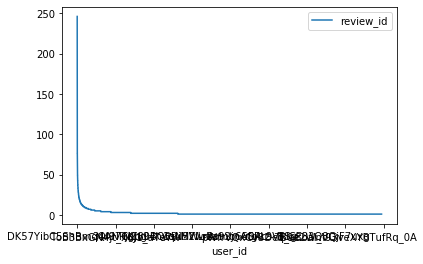

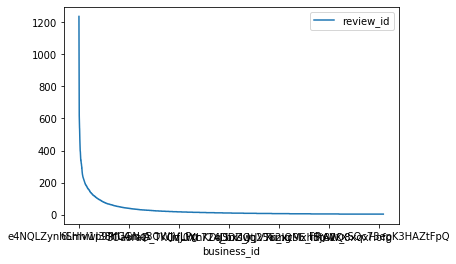

In [29]:
# reset index
df_reviews = df_reviews.reset_index()

# count reviews per user and reviews per business
reviews_per_user = df_reviews.groupby("user_id")["review_id"].count().sort_values(ascending=False).to_frame()
reviews_per_business = df_reviews.groupby("business_id")["review_id"].count().sort_values(ascending=False).to_frame()


# plot both review counts
user_plot = reviews_per_user.plot()
business_plot = reviews_per_business.plot()

user_id
RtGqdDBvvBCjcu5dUqwfzA    12390
XYSDrIef7g4Gmp3lNFVO6A     4551
m07sy7eLtOjVdZ8oN9JKag     4400
U4INQZOPSUaj8hMjLlZ3KA     4308
cMEtAiW60I5wE_vLfTxoJQ     4190
                          ...  
08PdgEjxWKeJAOZa5pgiYA        5
xrY3JFdFmv5kAulxKzVJpw        4
kn52OchuJ_WK3jThxtqKyA        3
I0q9S5mp4HOHmUbho1rnLg        2
j-UicIfNOWVJvk4e0E6PtA        1
Name: review_count, Length: 830, dtype: int64

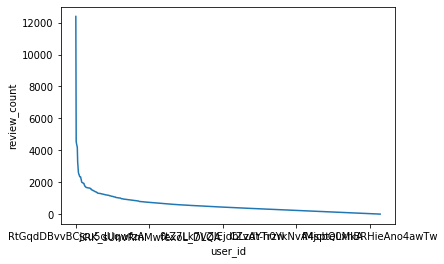

In [30]:
"""""
userplot --> the distribution of the reviews over the users (long-tail): considering the fact that there are more
reviews on business than users (one user can rate more than 1 business), it is probably better to choose
item-based CF than user-based CF. 

"""""
users_series = df_users['review_count'].sort_values(ascending=False).drop_duplicates(keep='first')

display(users_series)
userplot = users_series.plot()

userplot.set(xlabel='user_id', ylabel='review_count')
plt.show()

### Implementation <a name='implementation'></a>


[Top](#Top)

### Deel 1: Mesa <a name='mesa'></a>

[Top](#Top)

In [31]:
reviews = df_reviews[:5000]
reviews

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,-I5umRTkhw15RqpKMl_o1Q,-mA3-1mN4JIEkqOtdbNXCQ,mRUVMJkUGxrByzMQ2MuOpA,1.0,0,1,0,"Walked in around 4 on a Friday afternoon, we s...",2017-12-15 23:27:08
1,I9HBDyzCqLhTYHCAZIFZQQ,vXZeHaLvdfCPATz5BDavow,FQ1wBQb3aNeRMThSQEV0Qg,5.0,4,0,0,PlumbSmart provided superior service from begi...,2013-12-07 02:32:45
2,NfK6qaAr5QgbuMG0XDbpuQ,-bFRtLmkx7aXKf0oqFKpRg,1Kq_blM7ROYESz6i6FI_QQ,4.0,1,0,0,"I've taken my kids here several times, and we'...",2013-05-07 03:40:19
3,NFlW7_5bOPkR2Nz8t9d2Sw,qkQ5iVnEdqSxjd3faoRTpw,Kz4WS00PcqOJgxfZawk4dQ,4.0,0,0,1,"I love Pizza, but I try to stay away for dieta...",2013-12-07 01:41:25
4,niN5qW_M5Y0W0zQEcQcFig,n5E4KzRRGosdxNcdyyZztg,9nHpqlu7be1466wdo_t5kQ,2.0,0,0,0,My family and I came in on Wed. Night for dinn...,2018-03-15 20:12:39
...,...,...,...,...,...,...,...,...,...
4995,wGQ-7BMJqQr7xS_zWNmfVQ,viAm7Otbn_8dSabR2Kj6lw,mLg4FenOcHpXZnW67QrVxw,5.0,1,0,0,I was lucky to have Chris and Ed work on my ch...,2016-01-22 21:56:25
4996,BPoZC0cwjwaHH463sf7z2A,JWxjy0p_ASQNLiNRwlig6A,c8M0snWaVUIw9ct_r9a7vw,3.0,5,1,1,Had car transported enclosed across country fo...,2015-05-17 16:05:50
4997,m9VgGMyCyk5LylPFrHL5Vw,EXKDLuYoZUKUNNNYA7TlGQ,pJQSdbrtQQVstMUUIICSsA,5.0,10,5,12,I love this theatre. They have 25 screens. the...,2016-02-29 02:34:49
4998,5RWbI5lw2HeVjgb1vyNCpg,LZHyRPi_czMKnQagkwX7yg,P0IY-8h2q--Uiw6vKIJ3QQ,5.0,0,0,0,"Really, really good Cantonese cuisine... Hot, ...",2017-02-15 01:40:46


In [32]:
def pivot_ratings(ratings):
    pivottable = ratings.pivot_table(index="business_id", columns="user_id", values="stars").fillna(0)
    return pivottable

utility_matrix = pivot_ratings(reviews)
display(utility_matrix.loc['mRUVMJkUGxrByzMQ2MuOpA'][utility_matrix.loc['mRUVMJkUGxrByzMQ2MuOpA'].notna()])
display(utility_matrix)

user_id
--kST1ahJN2_Yym3keOzHQ    0.0
-0IiMAZI2SsQ7VmyzJjokQ    0.0
-0aInSHjCWLfiNqfgmWnow    0.0
-1QntIRTVBABpiojwhEoyA    0.0
-25edxRviMBTTnM4LTSwWA    0.0
                         ... 
zuPa005MlBtapaPIdCEV2g    0.0
zw3005g3VOz5_oxdpljqhw    0.0
zwpP3Lt8USKS91Ds52G8UA    0.0
zxGQl6-4k8Q-klqF0XR_dg    0.0
zznZTSALzMXf3cjggfNdBQ    0.0
Name: mRUVMJkUGxrByzMQ2MuOpA, Length: 4500, dtype: float64

user_id,--kST1ahJN2_Yym3keOzHQ,-0IiMAZI2SsQ7VmyzJjokQ,-0aInSHjCWLfiNqfgmWnow,-1QntIRTVBABpiojwhEoyA,-25edxRviMBTTnM4LTSwWA,-2oAgMWvhoJdEnV3iTVkqw,-4MHtUDle0HJGMjuBI6icA,-4t4Uxgwoc3uvyDkhJzF4g,-5U77U-utFhB5IjFS4uRvw,-5rx7QF_Q1zZbb7XwZ89Gg,...,zlFj4sJmPwzS1WdEB0FnFQ,zo9Gt3jZXmEJ1OLnOdLcig,zq50EWDSfYUWA26wNR6scw,zrvk0-B91ahJRSB-UcAmIA,zuKC-dcRmJ8dUgwUSbNT1g,zuPa005MlBtapaPIdCEV2g,zw3005g3VOz5_oxdpljqhw,zwpP3Lt8USKS91Ds52G8UA,zxGQl6-4k8Q-klqF0XR_dg,zznZTSALzMXf3cjggfNdBQ
business_id,,,,,,,,,,,,,,,,,,,,,
-EfU6CLbv5b2oB5-bDnZ-w,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-L0QScIst3HnR52rNydTKQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-gRDDhLdkAfki50Dt5P9Og,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-qUUlgRB65oS5HXu8zJr2A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0BFQrm3kPCwC_V4MvbiBIA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zWLosp9soUtbEAe6oldrqQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zWrwVNAvrtVAhcDRWJJMEw,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zb_NGc44E6XjNxU4uOsPjA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
def cosine_distance(matrix, id1, id2):
    selected_features = matrix.loc[id1].notna() & matrix.loc[id2].notna()
    
    # if no matching features, return 'not a number' (NaN)
    if not selected_features.any():
        return np.nan
    
    # get the features from the matrix
    features1 = matrix.loc[id1][selected_features]
    features2 = matrix.loc[id2][selected_features]

    #if sum(features1)==0. or sum(features2)==0.:
        #return 1.
    
    if id1 == id2:
        return 1.
    
    sim = (np.sqrt(sum(features1**2))*np.sqrt(sum(features2**2)))
    
    if sim == 0.:
        return np.nan
    
    return sum(features1*features2)/sim
    
def create_similarity_matrix_cosine(matrix):
    similarity_matrix = pd.DataFrame(0, index=matrix.index, columns=matrix.index, dtype=float)
    # Iter of rows & columns, cause I couldnt get apply/-map to work
    for index, row in similarity_matrix.iteritems():
        for i in row.index:
            similarity_matrix.at[index,i] = cosine_distance(matrix,index,i)
    
    return similarity_matrix

#display(create_similarity_matrix_euclid(matrix))
    
#similarity = create_similarity_matrix_cosine(utility_matrix)
#display(similarity)

In [34]:
def mean_center_columns(matrix):
#     return matrix.apply(lambda x: x - x.mean())

# centered_utility_matrix = mean_center_columns(utility_matrix)
# display(centered_utility_matrix)

# similarity = create_similarity_matrix_cosine(centered_utility_matrix)
# display(similarity)

    mean_centered = matrix.copy()
    for col in list(matrix.columns):
        mean_centered[col] -= matrix[col].mean()
        
    return mean_centered


centered_utility_matrix = mean_center_columns(utility_matrix)
display(centered_utility_matrix)


similarity = create_similarity_matrix_cosine(centered_utility_matrix)
display(similarity)

user_id,--kST1ahJN2_Yym3keOzHQ,-0IiMAZI2SsQ7VmyzJjokQ,-0aInSHjCWLfiNqfgmWnow,-1QntIRTVBABpiojwhEoyA,-25edxRviMBTTnM4LTSwWA,-2oAgMWvhoJdEnV3iTVkqw,-4MHtUDle0HJGMjuBI6icA,-4t4Uxgwoc3uvyDkhJzF4g,-5U77U-utFhB5IjFS4uRvw,-5rx7QF_Q1zZbb7XwZ89Gg,...,zlFj4sJmPwzS1WdEB0FnFQ,zo9Gt3jZXmEJ1OLnOdLcig,zq50EWDSfYUWA26wNR6scw,zrvk0-B91ahJRSB-UcAmIA,zuKC-dcRmJ8dUgwUSbNT1g,zuPa005MlBtapaPIdCEV2g,zw3005g3VOz5_oxdpljqhw,zwpP3Lt8USKS91Ds52G8UA,zxGQl6-4k8Q-klqF0XR_dg,zznZTSALzMXf3cjggfNdBQ
business_id,,,,,,,,,,,,,,,,,,,,,
-EfU6CLbv5b2oB5-bDnZ-w,-0.009728,-0.001946,-0.01751,-0.009728,-0.001946,-0.007782,-0.001946,-0.007782,-0.009728,-0.009728,...,-0.005837,-0.009728,-0.009728,-0.027237,-0.009728,-0.009728,-0.009728,-0.01751,-0.007782,-0.001946
-L0QScIst3HnR52rNydTKQ,-0.009728,-0.001946,-0.01751,-0.009728,-0.001946,-0.007782,-0.001946,-0.007782,-0.009728,-0.009728,...,-0.005837,-0.009728,-0.009728,-0.027237,-0.009728,-0.009728,-0.009728,-0.01751,-0.007782,-0.001946
-gRDDhLdkAfki50Dt5P9Og,-0.009728,-0.001946,-0.01751,-0.009728,-0.001946,-0.007782,-0.001946,-0.007782,-0.009728,-0.009728,...,-0.005837,-0.009728,-0.009728,-0.027237,-0.009728,-0.009728,-0.009728,-0.01751,-0.007782,-0.001946
-qUUlgRB65oS5HXu8zJr2A,-0.009728,-0.001946,-0.01751,-0.009728,-0.001946,-0.007782,-0.001946,-0.007782,-0.009728,-0.009728,...,-0.005837,-0.009728,-0.009728,-0.027237,-0.009728,-0.009728,-0.009728,-0.01751,-0.007782,-0.001946
0BFQrm3kPCwC_V4MvbiBIA,-0.009728,-0.001946,-0.01751,-0.009728,-0.001946,-0.007782,-0.001946,-0.007782,-0.009728,-0.009728,...,-0.005837,-0.009728,-0.009728,-0.027237,-0.009728,-0.009728,-0.009728,-0.01751,-0.007782,-0.001946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zWLosp9soUtbEAe6oldrqQ,-0.009728,-0.001946,-0.01751,-0.009728,-0.001946,-0.007782,-0.001946,-0.007782,-0.009728,-0.009728,...,-0.005837,-0.009728,-0.009728,-0.027237,-0.009728,-0.009728,-0.009728,-0.01751,-0.007782,-0.001946
zWrwVNAvrtVAhcDRWJJMEw,-0.009728,-0.001946,-0.01751,-0.009728,-0.001946,-0.007782,-0.001946,-0.007782,-0.009728,-0.009728,...,-0.005837,-0.009728,-0.009728,-0.027237,-0.009728,-0.009728,-0.009728,-0.01751,-0.007782,-0.001946
zb_NGc44E6XjNxU4uOsPjA,-0.009728,-0.001946,-0.01751,-0.009728,-0.001946,-0.007782,-0.001946,-0.007782,-0.009728,-0.009728,...,-0.005837,-0.009728,-0.009728,-0.027237,-0.009728,-0.009728,-0.009728,-0.01751,-0.007782,-0.001946


business_id,-EfU6CLbv5b2oB5-bDnZ-w,-L0QScIst3HnR52rNydTKQ,-gRDDhLdkAfki50Dt5P9Og,-qUUlgRB65oS5HXu8zJr2A,0BFQrm3kPCwC_V4MvbiBIA,0Iaqx34HsUWc2MnZ0OPgcA,0JLkGesHFja7sEmtjiijHQ,0MAubmdZUjeCHlqy5nMuDw,0NIXu8EWhXcKqrY2rg2Dqw,0NpOMGr1r_m4cJh5KVdYcw,...,yh0C-9INiI-c-mNoeX8LIw,ylUmcgkA1WgBfSad7njEvw,z8f9rW38nSlAVVSOeyJPFA,zBTtG3c8IVODlrrnBbL93g,zKkrqb2Q_c0ztTyTX1ZSlg,zWLosp9soUtbEAe6oldrqQ,zWrwVNAvrtVAhcDRWJJMEw,zb_NGc44E6XjNxU4uOsPjA,zeyWoxymwl4sNoK2kn5-Yg,zkQPk9lb88VsHj4VPEz5HQ
business_id,,,,,,,,,,,,,,,,,,,,,
-EfU6CLbv5b2oB5-bDnZ-w,1.000000,0.002808,-0.002078,0.001256,0.002808,0.012355,0.002808,0.001256,0.001095,0.002713,...,-0.000153,0.012355,-0.001585,0.016478,0.000305,-0.000878,0.006864,0.008881,0.002808,-0.003519
-L0QScIst3HnR52rNydTKQ,0.002808,1.000000,-0.002338,0.005721,0.009988,0.038620,0.009988,0.005721,0.005296,0.009722,...,0.002116,0.038620,-0.001243,0.051280,0.003336,0.000460,0.023185,0.028016,0.009988,-0.005272
-gRDDhLdkAfki50Dt5P9Og,-0.002078,-0.002338,1.000000,-0.002094,-0.002338,-0.005825,-0.002338,-0.002094,-0.002082,-0.002317,...,-0.002099,-0.005825,-0.002358,-0.007578,-0.002138,-0.002268,-0.004682,-0.004400,-0.002338,-0.003133
-qUUlgRB65oS5HXu8zJr2A,0.001256,0.005721,-0.002094,1.000000,0.005721,0.022915,0.005721,0.003090,0.002824,0.005558,...,0.000815,0.022915,-0.001368,0.030466,0.001574,-0.000272,0.013463,0.016580,0.005721,-0.004101
0BFQrm3kPCwC_V4MvbiBIA,0.002808,0.009988,-0.002338,0.005721,1.000000,0.038620,0.009988,0.005721,0.005296,0.009722,...,0.002116,0.038620,-0.001243,0.051280,0.003336,0.000460,0.023185,0.028016,0.009988,-0.005272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zWLosp9soUtbEAe6oldrqQ,-0.000878,0.000460,-0.002268,-0.000272,0.000460,0.004058,0.000460,-0.000272,-0.000354,0.000418,...,-0.001040,0.004058,-0.001936,0.005500,-0.000809,1.000000,0.001596,0.002820,0.000460,-0.003340
zWrwVNAvrtVAhcDRWJJMEw,0.006864,0.023185,-0.004682,0.013463,0.023185,0.088856,0.023185,0.013463,0.012498,0.022575,...,0.005304,0.088856,-0.002238,0.117948,0.008075,0.001596,1.000000,0.064502,0.023185,-0.011170
zb_NGc44E6XjNxU4uOsPjA,0.008881,0.028016,-0.004400,0.016580,0.028016,0.106046,0.028016,0.016580,0.015450,0.027297,...,0.007071,0.106046,-0.001611,0.140701,0.010319,0.002820,0.064502,1.000000,0.028016,-0.011696


In [35]:
similarity.to_pickle('./similarity_pickle.pkl')
similarity_matrix_mesa = pd.read_pickle('./similarity_pickle.pkl')

In [36]:
# TEST neighborhood op eentje

#def select_neighborhood(similarities, ratings, k):
#    """ selects all items with similarity > 0  """
#    moviesNotWatched = ratings[ratings.isna()].index
    
#    similarities = similarities.where(lambda x : x > 0.00).dropna()
#    similarities = similarities.drop(labels=moviesNotWatched,errors='ignore')
    
#    return similarities.sort_values(ascending=False)[:k]

def select_neighborhood(similarities, ratings, k):
    """ selects all items with similarity > 0  """
    # drop all not rated businesses
    
    for key,v in ratings.iteritems():
        if np.isnan(v):
            similarities = similarities.drop(labels=key)
    
    for key,v in similarities.iteritems():
        if not v > 0.:
            similarities = similarities.drop(labels=key)
            
    similarities = similarities.sort_values(ascending=False)
    
    return similarities[:k]

neighborhood = select_neighborhood(similarity["mRUVMJkUGxrByzMQ2MuOpA"], utility_matrix["6G6_qNcvzRgAQdr2AWvkKw"], 10)
display(neighborhood)

business_id
mRUVMJkUGxrByzMQ2MuOpA    1.000000
4VqV8RcVtXOfWQEEK0_h2g    0.281376
TectsyEvH5vmlgtYQ7Sjsw    0.137354
9nHpqlu7be1466wdo_t5kQ    0.058720
mGriYfWJcLJGjkuqr0a5OA    0.031584
GOOaZ6WmjtJGYnM8Tu0W8g    0.017235
Kz4WS00PcqOJgxfZawk4dQ    0.012179
Name: mRUVMJkUGxrByzMQ2MuOpA, dtype: float64

In [37]:
# TEST
def weighted_mean(neighborhood, ratings):  
    upper = 0.
    bottom = 0.
    
    for index in neighborhood.index:
        similarity = neighborhood.get(index)
        upper += ratings.get(index) * similarity
        bottom += similarity
    
    if bottom == 0.:
        return np.nan
    else:
        return upper / bottom

neighborhood1 = select_neighborhood(similarity["mRUVMJkUGxrByzMQ2MuOpA"], utility_matrix["6G6_qNcvzRgAQdr2AWvkKw"], 10)
prediction1 = weighted_mean(neighborhood1, utility_matrix["6G6_qNcvzRgAQdr2AWvkKw"])


print(f"User 6G6_qNcvzRgAQdr2AWvkKw predicted rating for business mRUVMJkUGxrByzMQ2MuOpA is {prediction1:.2f}")


User 6G6_qNcvzRgAQdr2AWvkKw predicted rating for business mRUVMJkUGxrByzMQ2MuOpA is 0.65


In [38]:
reviews_copy = reviews.copy()
training_set = reviews_copy.sample(frac=0.80, random_state=0)[["business_id", "user_id", "stars"]]
test_set = reviews_copy.drop(training_set.index)[["business_id", "user_id", "stars"]]

# display(training_set)
# display(test_set)

In [39]:
def predict_ratings_item_based(similarity, utility, user_item_pairs):
    ratings_test_c = user_item_pairs.copy()
    ratings_test_c['predicted rating'] = 0.
    for index,row in user_item_pairs.iterrows():
        neighborhood = select_neighborhood(similarity[row['business_id']],utility[row['user_id']],1000)
        ratings_test_c.at[index,'predicted rating'] = weighted_mean(neighborhood,utility[row['user_id']])
    return ratings_test_c

predicted_item_based = predict_ratings_item_based(similarity, utility_matrix, test_set)
display(predicted_item_based.head())

,business_id,user_id,stars,predicted rating
0,mRUVMJkUGxrByzMQ2MuOpA,-mA3-1mN4JIEkqOtdbNXCQ,1.0,0.650006
7,WDMn7XrMUV2T2cF0w7m0Nw,qkMChMKj4evqii0rfFxhXg,5.0,5.000000
21,ExD6juQhcCbw_u8lwksJdQ,ME1yRzbc_uH7WZ2KfJuMFw,2.0,2.000000
24,MnXlZK3fCHZxgWFjFvU-bg,rLHnKcKZqgSeGVLn_eXL6w,5.0,4.816254
25,Vwo64kNYDjKi98gUUv4-iQ,htgBxTrrr0jyKXpEUuYwgQ,5.0,5.000000


### Predicted Ratings

In [40]:
PR_training = predict_ratings_item_based(similarity, utility_matrix, training_set)
PR_test = predict_ratings_item_based(similarity, utility_matrix, test_set)
display(PR_training)
display(PR_test)

,business_id,user_id,stars,predicted rating
398,yKaIT0fnxEj0YVr1DMHvuQ,s0ovC2froSvx4meypnYOng,5.0,4.625508
3833,n2PmOO8DyCGY1Tv2NBj4yA,CfV_axQI2rK0eHB9FfG_GQ,3.0,1.299850
4836,QUDbVp8p3vNK5dxeSrOalw,1J1wECaKO1sw8_iMKyDjKA,5.0,4.622618
4572,Kz4WS00PcqOJgxfZawk4dQ,LvPcZgUbzjcdUVCqYrefjg,5.0,3.128401
636,0fxSNcE0IWJNL7oiOcyayA,IWgPxpIxYwHCq6WDbpzFIQ,1.0,0.452472
...,...,...,...,...
2061,mJBeo-CC0VG6ebDniGfgqw,ZL0AEkN6n5_WY1t-N9qNTA,4.0,3.527724
4211,3Lx-d2iTUoMdwJ9sxVw6XQ,IBD4qGGSYvPX9-r8kHBgTw,1.0,1.000000
2018,kNWGvHFMvibZ8vRrxw5YhA,E2YWFOG_67SraRIOSdWbpA,5.0,2.724649
3940,K0BwkpkeVKgp0gVIeiTEOA,KQMzfaaI9jfo68S4CsCifA,3.0,0.602330


,business_id,user_id,stars,predicted rating
0,mRUVMJkUGxrByzMQ2MuOpA,-mA3-1mN4JIEkqOtdbNXCQ,1.0,0.650006
7,WDMn7XrMUV2T2cF0w7m0Nw,qkMChMKj4evqii0rfFxhXg,5.0,5.000000
21,ExD6juQhcCbw_u8lwksJdQ,ME1yRzbc_uH7WZ2KfJuMFw,2.0,2.000000
24,MnXlZK3fCHZxgWFjFvU-bg,rLHnKcKZqgSeGVLn_eXL6w,5.0,4.816254
25,Vwo64kNYDjKi98gUUv4-iQ,htgBxTrrr0jyKXpEUuYwgQ,5.0,5.000000
...,...,...,...,...
4978,vIvFJ7hMxT0JqkM_BY67-w,PlL_Xd0RBgtxhCSJ1lZMZQ,5.0,4.905369
4985,4XxWx9r1IFqh1ndEJwLyDw,2Kv4VZv3IOAxcP-kvEf28Q,1.0,0.222682
4986,6MpRsUKPpGUXklU2bYHUDg,Eu1xgVI811YhVIqG1yyMHQ,2.0,1.571747
4991,coo1x2Qu_bwMsLzDsC0NRQ,zw3005g3VOz5_oxdpljqhw,5.0,4.660477


### MSE Predicted Ratings

In [41]:
def mse(predicted_ratings):
    return sum((predicted_ratings['stars']-predicted_ratings['predicted rating'])**2)/len(predicted_ratings)

mse_item_based_training = mse(PR_training)
mse_item_based_test = mse(PR_test)

display(mse_item_based_training)
display(mse_item_based_test)

1.799823219315935

1.7745613209128055

### Random Predictions

In [42]:
mse_random = 0
predicted_random = test_set.copy()[['user_id', 'business_id', 'stars']]
predicted_random['predicted rating'] = 4.5 * np.random.random_sample((len(predicted_random),)) + 0.5

display(predicted_random.head())

mse_random = mse(predicted_random)

print(f"mse for item based prediction: {mse_item_based_test:.2f}")
print(f"mse for random prediction: {mse_random:.2f}")

,user_id,business_id,stars,predicted rating
0,-mA3-1mN4JIEkqOtdbNXCQ,mRUVMJkUGxrByzMQ2MuOpA,1.0,1.832690
7,qkMChMKj4evqii0rfFxhXg,WDMn7XrMUV2T2cF0w7m0Nw,5.0,3.640057
21,ME1yRzbc_uH7WZ2KfJuMFw,ExD6juQhcCbw_u8lwksJdQ,2.0,3.943907
24,rLHnKcKZqgSeGVLn_eXL6w,MnXlZK3fCHZxgWFjFvU-bg,5.0,0.587149
25,htgBxTrrr0jyKXpEUuYwgQ,Vwo64kNYDjKi98gUUv4-iQ,5.0,0.551218


mse for item based prediction: 1.77
mse for random prediction: 5.10


### Deel 2: Henderson <a name='henderson'></a>

[Top](#Top)

### Utility Matrix & Similarity Matrix

In [ ]:
reviews = df_reviews[:5000]

### Utility Matrix

In [ ]:
def pivot_ratings(ratings):
    pivottable = ratings.pivot_table(index="business_id", columns="user_id", values="stars").fillna(0)
    return pivottable

utility_matrix = pivot_ratings(reviews)
display(utility_matrix)

### Similarity

In [ ]:
def cosine_similarity(matrix, id1, id2):
    
    selected_features = matrix.loc[id1].notna() & matrix.loc[id2].notna()
    features1 = matrix.loc[id1][selected_features]
    features2 = matrix.loc[id2][selected_features]
    
    if id1 == id2:
        return 1
    
    elif selected_features.any() == False:
        return np.nan
                                                                                                
    if (features1==0).all() and (features2==0).all() == True:
         return np.nan
    elif (features1==0).all() or (features2==0).all() == True:
         return np.nan
                                                   
    else:
         
        teller = sum(features1*features2)
        noemer = np.sqrt(sum(features1**2)) * np.sqrt(sum(features2**2))
        cos = teller / noemer   
        
        return cos 


def create_similarity_matrix_cosine(matrix):
    
    cosine_similarity_matrix = pd.DataFrame(0, index=matrix.index, columns=matrix.index, dtype=float)
    
    for i1 in matrix.index.values:
        for i2 in matrix.index.values:
            similarity = cosine_similarity(matrix, i1, i2)
            cosine_similarity_matrix[i1][i2] = similarity
    
    return cosine_similarity_matrix


#similarity = create_similarity_matrix_cosine(utility_matrix)
#display(similarity)

### Mean Centering

In [ ]:
def mean_center_columns(matrix):
    result = matrix.copy()
    
    for i in result.columns.values:
        m = result[i].mean()
        for j in result.index.values:
            result[i][j] = result[i][j] - m
            
    return result


centered_utility_matrix = mean_center_columns(utility_matrix)
display(centered_utility_matrix)


similarity = create_similarity_matrix_cosine(centered_utility_matrix)
display(similarity)

In [ ]:
similarity.to_pickle('./similarity_pickle.pkl')

In [ ]:
similarity = pd.read_pickle('./similarity_pickle.pkl')

### Neighborhood

In [ ]:
def select_neighborhood(similarities, ratings, k):
    """ selects all items with similarity > 0  """
   
    results = {}
    
    for i in similarities.index.values:
        if similarities[i]>0.000 and not np.isnan(ratings[i]):
            print(similarities[i])
            results[i] = similarities[i]
    
    df = pd.Series(results)
        
    
    return df.sort_values(ascending=False)[:k]  
        
    
#print(similarity["-3n__pVgU99k4jaSANVFgw"], utility_matrix["-InhDRRVG7wrwsgAUvN4Qw"])
neighborhood = select_neighborhood(similarity["znRorbwFubHZaACq8qj2Rg"], utility_matrix["zyFu57CLm1q752bkG9OjXQ"], 10)
display(neighborhood)

In [ ]:
reviews_copy = reviews.copy()
training_set = reviews_copy.sample(frac=0.80, random_state=0)[["business_id", "user_id", "stars"]]
test_set = reviews_copy.drop(training_set.index)[["business_id", "user_id", "stars"]]

display(training_set)
display(test_set)

### Voorspelling

In [ ]:
def weighted_mean(neighborhood, ratings):  
    
    a = 0.
    b = 0.
    
    for (i, m) in neighborhood.iteritems():
        a += m * ratings[i]
        b += m 

    print(ratings)   
    
    if b == 0.:
        return np.nan
    else:
        return a/b
    
neighborhood = select_neighborhood(similarity["znRorbwFubHZaACq8qj2Rg"], utility_matrix["zyFu57CLm1q752bkG9OjXQ"], 10)
prediction = weighted_mean(neighborhood, utility_matrix["zyFu57CLm1q752bkG9OjXQ"])
print(f'User "-0HhZbPBlB1YZx3BhAfaEA" predicted rating for "zyFu57CLm1q752bkG9OjXQ" is {prediction:.3f}')

### Baseline

### Predict Ratings

In [ ]:
def predict_ratings_item_based(similarity, utility, user_item_pairs):
    ratings_test_c = user_item_pairs.copy()
    ratings_test_c['predicted rating'] = 0.
    for index,row in user_item_pairs.iterrows():
        neighborhood = select_neighborhood(similarity[row['business_id']],utility[row['user_id']],1000)
        ratings_test_c.at[index,'predicted rating'] = weighted_mean(neighborhood,utility[row['user_id']])
    return ratings_test_c

In [ ]:
PR_training = predict_ratings_item_based(similarity, utility_matrix, training_set)
PR_test = predict_ratings_item_based(similarity, utility_matrix, test_set)

#display(PR_training)
#display(PR_test)
#PR = predict_ratings_item_based(similarity, utility_matrix, test_set)
#test_data = df_reviews[:500][['business_id','user_id','stars']].copy()
#display(PR)

### MSE Predicted Ratings


In [ ]:
def mse(predicted_ratings):
    return sum((predicted_ratings['stars']-predicted_ratings['predicted rating'])**2)/len(predicted_ratings)

mse_item_based_training = mse(PR_training)
mse_item_based_test = mse(PR_test)

display(mse_item_based_training)
display(mse_item_based_test)

### MSE Random Predictions

In [ ]:
mse_random = 0
predicted_random = test_set.copy()[['user_id', 'business_id', 'stars']]
predicted_random['predicted rating'] = 4.5 * np.random.random_sample((len(predicted_random),)) + 0.5

display(predicted_random.head())

mse_random = mse(predicted_random)
print(f'mse for item based prediction: {mse_item_based_test:.2f}')
print(f'mse for random prediction: {mse_random:.2f}')

# Evaluatie

In [110]:
# Create a copy of the DataFrame
# Split data in training and test set

reviews_copy = reviews.copy()
training_set = reviews_copy.sample(frac=0.80, random_state=0)
test_set = reviews_copy.drop(training_set.index)

### Recommended, Hidden, Used en Unused

In [112]:
def recommended(predictions, threshold):
    return predictions[predictions['predicted rating']>=threshold]


def hidden(predictions, threshold):
    return predictions[predictions['predicted rating']<threshold]
    
#predicted_item_based    
treshold_recommended = 3.75
recommended_items = recommended(PR_test, treshold_recommended)
hidden_items = hidden(PR_test, treshold_recommended)

print(f'Test items : {PR_test.shape[0]}')
print(f'Recommended: {recommended_items.shape[0]}')
print(f'Hidden     : {hidden_items.shape[0]}')
display(recommended_items.head())
display(hidden_items.head())

Test items : 1000
Recommended: 313
Hidden     : 687


,business_id,user_id,stars,predicted rating
7,WDMn7XrMUV2T2cF0w7m0Nw,qkMChMKj4evqii0rfFxhXg,5.0,5.000000
24,MnXlZK3fCHZxgWFjFvU-bg,rLHnKcKZqgSeGVLn_eXL6w,5.0,4.816254
25,Vwo64kNYDjKi98gUUv4-iQ,htgBxTrrr0jyKXpEUuYwgQ,5.0,5.000000
35,c8M0snWaVUIw9ct_r9a7vw,yj4L0JFEO7Wkto3vv3Rm4g,5.0,5.000000
60,HKzBh4pMTGF7oajNoADx7Q,Npm3lnPhQE1NYEcsuXrsCA,5.0,4.024974


,business_id,user_id,stars,predicted rating
0,mRUVMJkUGxrByzMQ2MuOpA,-mA3-1mN4JIEkqOtdbNXCQ,1.0,0.650006
21,ExD6juQhcCbw_u8lwksJdQ,ME1yRzbc_uH7WZ2KfJuMFw,2.0,2.000000
28,6d2hdz6IuFRDYJkYo9vR0g,wuADnbFkBrC8uy5kUGT4vg,2.0,0.163594
56,4xfYFf__ushFQKncEdSZ0g,v15qziW5NRbveksIoiDnqQ,4.0,2.337141
62,zkQPk9lb88VsHj4VPEz5HQ,WOwXnH07iymJmPiLdKfoog,5.0,3.680413


In [113]:
def used(predictions, threshold):
    return predictions[predictions['stars']>=threshold]
    

def unused(predictions, threshold):
    return predictions[predictions['stars']<threshold]
    
    
treshold_used = 4.0
used_items = used(PR_test, treshold_used)
unused_items = unused(PR_test, treshold_used)

print(f'Test items: {PR_test.shape[0]}')
print(f'Used      : {used_items.shape[0]}')
print(f'Unused    : {unused_items.shape[0]}')
display(used_items.head())
display(unused_items.head())

Test items: 1000
Used      : 617
Unused    : 383


,business_id,user_id,stars,predicted rating
7,WDMn7XrMUV2T2cF0w7m0Nw,qkMChMKj4evqii0rfFxhXg,5.0,5.000000
24,MnXlZK3fCHZxgWFjFvU-bg,rLHnKcKZqgSeGVLn_eXL6w,5.0,4.816254
25,Vwo64kNYDjKi98gUUv4-iQ,htgBxTrrr0jyKXpEUuYwgQ,5.0,5.000000
35,c8M0snWaVUIw9ct_r9a7vw,yj4L0JFEO7Wkto3vv3Rm4g,5.0,5.000000
56,4xfYFf__ushFQKncEdSZ0g,v15qziW5NRbveksIoiDnqQ,4.0,2.337141


,business_id,user_id,stars,predicted rating
0,mRUVMJkUGxrByzMQ2MuOpA,-mA3-1mN4JIEkqOtdbNXCQ,1.0,0.650006
21,ExD6juQhcCbw_u8lwksJdQ,ME1yRzbc_uH7WZ2KfJuMFw,2.0,2.000000
28,6d2hdz6IuFRDYJkYo9vR0g,wuADnbFkBrC8uy5kUGT4vg,2.0,0.163594
63,ky-95LNb9ol7yF3OzWQaBQ,N3PQsMWSoUEjcrQrNnlSWA,2.0,0.603957
94,AXhTU2DzkI0xhHwqSmqY8A,cJshXISsMBDVIiUO_mCl1A,1.0,0.248196


### Confusion Matrix

In [114]:
def confusion(recommended, hidden, used, unused): 
    TP = len(recommended.merge(used)) 
    FP = len(recommended.merge(unused)) 
    TN = len(hidden.merge(unused))
    FN = len(hidden.merge(used))
    
    return pd.DataFrame([[TP, FP], [FN, TN]], index=['recommended', 'hidden'], columns=['used', 'unused'])

confusion_matrix = confusion(recommended_items, hidden_items, used_items, unused_items)
display(confusion_matrix)

,used,unused
recommended,313,0
hidden,304,387


### Precision Recall

In [115]:
def precision(confusion_matrix):
    return confusion_matrix.at['recommended','used']/(confusion_matrix.at['recommended','used']+confusion_matrix.at['recommended','unused'])

precision_item_based = precision(confusion_matrix)

def recall(confusion_matrix):
    return confusion_matrix.at['recommended','used']/(confusion_matrix.at['recommended','used']+confusion_matrix.at['hidden','used'])

recall_item_based = recall(confusion_matrix)

print(f'precision for item based prediction: {precision_item_based:.2f}')
print(f'recall for item based prediction: {recall_item_based:.2f}')

precision for item based prediction: 1.00
recall for item based prediction: 0.51


In [116]:
treshold_recommended = 3.75
treshold_used = 4.0

recommended_item_based = recommended(PR_test, treshold_recommended)
hidden_item_based = hidden(PR_test, treshold_recommended)
used_item_based = used(PR_test, treshold_used)
unused_item_based = unused(PR_test, treshold_used)

recommended_random = recommended(predicted_random, treshold_recommended)
hidden_random = hidden(predicted_random, treshold_recommended)
used_random = used(predicted_random, treshold_used)
unused_random = unused(predicted_random, treshold_used)

confusion_item_based = confusion(recommended_item_based,hidden_item_based,used_item_based,unused_item_based)
confusion_random = confusion(recommended_random, hidden_random,used_random,unused_random)

precision_random = precision(confusion_random)
recall_random = recall(confusion_random)

print('           | precision | recall')
print(f'item based |      {precision_item_based:.2f} |   {recall_item_based:.2f}')
print(f'random     |      {precision_random:.2f} |   {recall_random:.2f}')


           | precision | recall
item based |      1.00 |   0.51
random     |      0.62 |   0.28


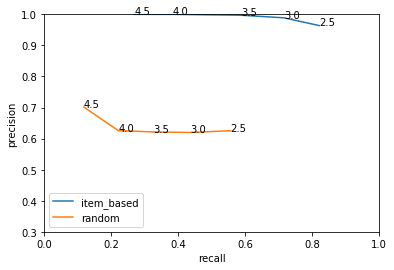

In [117]:
treshold_used = 3.75
treshold_recommended = [2.5,3.,3.5,4.,4.5]

recommended_item_based = [recommended(PR_test, thresh) for thresh in treshold_recommended]
hidden_item_based = [hidden(PR_test, thresh) for thresh in treshold_recommended]
used_item_based = used(PR_test, treshold_used)
unused_item_based = unused(PR_test, treshold_used)

recommended_random = [recommended(predicted_random, thresh) for thresh in treshold_recommended]
hidden_random = [hidden(predicted_random, thresh) for thresh in treshold_recommended]
used_random = used(predicted_random, treshold_used)
unused_random = unused(predicted_random, treshold_used)

confusion_item_based = [confusion(recommended_item_based[x],hidden_item_based[x],used_item_based,unused_item_based) for x in range(len(treshold_recommended))]
confusion_random = [confusion(recommended_random[x],hidden_random[x],used_random,unused_random) for x in range(len(treshold_recommended))]

precision_item_based = [precision(confusion_item_based[x]) for x in range(len(treshold_recommended))]
recall_item_based = [recall(confusion_item_based[x]) for x in range(len(treshold_recommended))]

precision_random = [precision(confusion_random[x]) for x in range(len(treshold_recommended))]
recall_random = [recall(confusion_random[x]) for x in range(len(treshold_recommended))]

plt.plot(recall_item_based, precision_item_based)
for r, p, t in zip(recall_item_based, precision_item_based, treshold_recommended):
    plt.text(r, p, t)

plt.plot(recall_random, precision_random)
for r, p, t in zip(recall_random, precision_random, treshold_recommended):
    plt.text(r, p, t)
    
plt.xlim(0.0, 1.0)
plt.ylim(0.3, 1.0)
plt.xlabel('recall')
plt.ylabel('precision')


plt.legend(['item_based','random'], loc = 'lower left')

### F1 Score

In [118]:
# F1 = 2 * (precision * recall) / (precision + recall)

F1_item = 2 * (precision_item_based[0] * recall_item_based[0]) / (precision_item_based[0] + recall_item_based[0])
F1_random = 2 * (precision_random[0] * recall_random[0]) / (precision_random[0] + recall_random[0])

display(F1_item)
display(F1_random)

0.8871391076115486

0.5895458440445587